# Massive Testing of Recurrent Adversarial Attacks

In [37]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PIL import Image

In [38]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

In [39]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

In [40]:
# Helper function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

In [41]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    print("Look here" + str(array.shape))
    return array

In [42]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also objectize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [43]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [44]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

In [45]:
def display_images(image, description):
  _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description,label, confidence*100))
  #data = str('{} {} : {:.2f}% Confidence'.format(description,label, confidence*100))
  #file = open("sports_car_general_adversarial_results.txt", "a")
  #file.write(data + "\n")
  #file.close()
  plt.show()

In [46]:
ep = np.arange(0.0, 1.0, 0.01)
epsilons = list(ep)

In [11]:
import glob
high_files = glob.glob("/Users/coltoncrum/Documents/Notre Dame/Research/Code/10.5.21/Object Perturbations/test_images/high/*")
high_files[0]

'/Users/coltoncrum/Documents/Notre Dame/Research/Code/10.5.21/Object Perturbations/test_images/high/bullfrog_1.jpeg'

In [ ]:
import tensorflow as tf
import numpy as np

tf.enable_eager_execution()

x = tf.constant([1., 2.])
print(type(perturbations))            # <type 'EagerTensor'>
print(type(perturbations.numpy()))    # <type 'numpy.ndarray'>
print(type(np.array(perturbations)))  # <type 'numpy.ndarray'>

# High Accuracy Images
# Object Perturbations

Look here(1, 224, 224, 3)
Predicted: [('n01641577', 'bullfrog', 9.205782)]


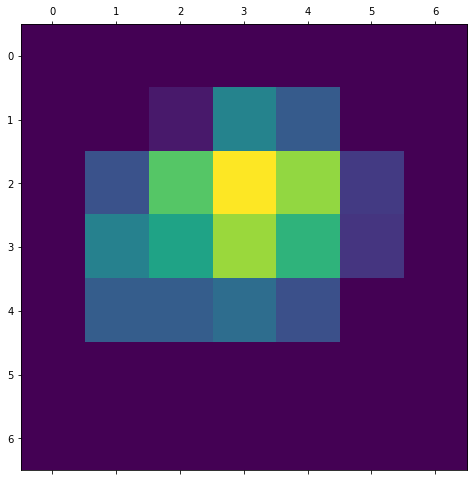

(7, 7)
Look here(1, 224, 224, 3)


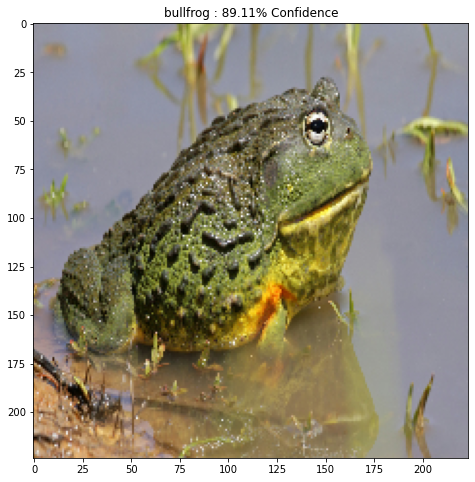

The Pert type <class 'numpy.ndarray'>
The Weights type <class 'numpy.ndarray'>
The Pert shape (1, 224, 224, 3)
The Weights shape (1, 224, 224, 3)


InvalidArgumentError: In[0] mismatch In[1] shape: 3 vs. 224: [1,224,224,3] [1,224,224,3] 0 0 [Op:BatchMatMulV2]

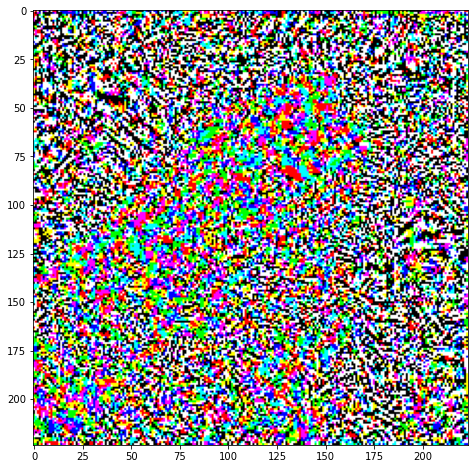

In [36]:
image_net_labels = [30, 30, 235, 817, 30]

for im, lab in zip(high_files, image_net_labels):
    name = im.replace('.jpeg','')
    name = name.replace('.jpg','')
    name = name.replace('/Users/coltoncrum/Documents/Notre Dame/Research/Code/10.5.21/Object Perturbations/test_images/high/','')
    
    cam_name = "./cam_images/high/cam_" + name
    cam_full_path = cam_name + ".jpg"
    
    def display_images(image, description):
      _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
      plt.figure()
      plt.imshow(image[0]*0.5+0.5)
      plt.title('{} \n {} : {:.2f}% Confidence'.format(description,label, confidence*100))
      data = str('{} {} : {:.2f}% Confidence'.format(description,label, confidence*100))
      file_path = "./results/high/" + name + "_object_adversarial_results.txt"
      file = open(file_path, "a")
      file.write(data + "\n")
      file.close()
      plt.show()
    
    def save_and_display_gradcam(img_path, heatmap, cam_path=cam_full_path, alpha=1):
    # Load the original image
        img = keras.preprocessing.image.load_img(img_path)
        img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
        heatmap = np.uint8(100 * heatmap)
        print(heatmap.shape)
    
    # Use jet colormap to colorize heatmap
        jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
        jet_colors = jet(np.arange(256))[:, :3]
        jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
        jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
        jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
        jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
        superimposed_img = jet_heatmap * alpha + img
        superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
        superimposed_img.save(cam_path)

    # Display Grad CAM
    #display(Image(cam_path))




    model_builder = keras.applications.MobileNetV2
    img_size = (224, 224)

    preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
    decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

    last_conv_layer_name = "Conv_1_bn"

# The local path to our target image
#img_path = keras.utils.get_file(
#    "YellowLabradorLooking_new.jpg", "https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg"
#)
    img_path = im
#display(Image(img_path))




# Prepare image
    img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
    model = model_builder(weights="imagenet")

# Remove last layer's softmax
    model.layers[-1].activation = None

# Print what the top predicted class is
    preds = model.predict(img_array)
    print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
    plt.matshow(heatmap)
    plt.show()



    img_scaled = NormalizeData(img_array)

    save_and_display_gradcam(img_path, heatmap)

    img_path = './cam_images/high/cam_' + name + '.jpg'
    img = Image.open(img_path).convert('L')
    img_new_path = './greyscale_cam/high/grey_' + name + '.jpg'
    img.save(img_new_path)


    image = Image.open(img_new_path)
    new_image = image.resize((224, 224))
    new_image_path = './grey_224/high/' + name + '_grey_224.jpg'
    new_image.save(new_image_path)


    grad_cam = get_img_array(new_image_path, (224, 224))

    weights = NormalizeData(grad_cam)

    #image_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
    image_path = im
    image_raw = tf.io.read_file(image_path)
    image = tf.image.decode_image(image_raw)

    image = preprocess(image)
    image_probs = pretrained_model.predict(image)

    plt.figure()
    plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
    _, image_class, class_confidence = get_imagenet_label(image_probs)
    plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
    plt.show()

# Get the input label of the image.
    labrador_retriever_index = lab # have to change the number everytime
    label = tf.one_hot(labrador_retriever_index, image_probs.shape[-1])
    label = tf.reshape(label, (1, image_probs.shape[-1]))

    perturbations = create_adversarial_pattern(image, label)
    plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

    #pert = perturbations.numpy()
    #pert = np.array(pert)
    #pert = tf.linalg.sq
    weights_convert = tf.convert_to_tensor(weights)
    pert_convert = tf.convert_to_tensor(pert)

    descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]
    print("The Pert type " + str(type(pert)))
    print("The Weights type " + str(type(weights)))
    print("The Pert shape " + str(pert.shape))
    print("The Weights shape " + str(weights.shape))

    #pert_weight = np.matmul(pert, weights)
    pert_weight = tf.linalg.matmul(pert_convert, weights_convert)
    for i, eps in enumerate(epsilons):
        #adv_x = image + eps * perturbations * weights
        adv_x = image + eps * pert_weight
        #adv_x = image + eps * perturbations * inverse_weights
        #adv_x = image + eps * perturbations
        adv_x = tf.clip_by_value(adv_x, -1, 1)
        display_images(adv_x, descriptions[i])

In [26]:
test = np.dot(weights.reshape(-1), pert.reshape(-1))

In [27]:
test

-256.362

In [24]:
weights.shape

(1, 224, 224, 3)

In [23]:
pert.shape

(1, 224, 224, 3)

In [29]:
adv_x.shape

TensorShape([1, 224, 224, 3])

In [32]:
pert_convert = tf.convert_to_tensor(pert)

In [33]:
pert_convert.shape

TensorShape([1, 224, 224, 3])

In [34]:
weights_convert = tf.convert_to_tensor(weights)

In [35]:
weights_convert.shape

TensorShape([1, 224, 224, 3])

# Medium Accuracy Images
# Object Perturbations

In [ ]:
import glob
high_files = glob.glob("/Users/coltoncrum/Documents/Notre Dame/Research/Code/10.5.21/Object Perturbations/test_images/medium/*")
high_files

In [ ]:
image_net_labels = [268, 187, 275, 30, 162]

for im, lab in zip(high_files, image_net_labels):
    name = im.replace('.jpeg','')
    name = name.replace('.jpg','')
    name = name.replace('/Users/coltoncrum/Documents/Notre Dame/Research/Code/10.5.21/Object Perturbations/test_images/medium/','')
    
    cam_name = "./cam_images/medium/cam_" + name
    cam_full_path = cam_name + ".jpg"
    
    def display_images(image, description):
      _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
      plt.figure()
      plt.imshow(image[0]*0.5+0.5)
      plt.title('{} \n {} : {:.2f}% Confidence'.format(description,label, confidence*100))
      data = str('{} {} : {:.2f}% Confidence'.format(description,label, confidence*100))
      file_path = "./results/medium/" + name + "_object_adversarial_results.txt"
      file = open(file_path, "a")
      file.write(data + "\n")
      file.close()
      plt.show()
    
    def save_and_display_gradcam(img_path, heatmap, cam_path=cam_full_path, alpha=1):
    # Load the original image
        img = keras.preprocessing.image.load_img(img_path)
        img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
        heatmap = np.uint8(100 * heatmap)
        print(heatmap.shape)
    
    # Use jet colormap to colorize heatmap
        jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
        jet_colors = jet(np.arange(256))[:, :3]
        jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
        jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
        jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
        jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
        superimposed_img = jet_heatmap * alpha + img
        superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
        superimposed_img.save(cam_path)

    # Display Grad CAM
    #display(Image(cam_path))




    model_builder = keras.applications.MobileNetV2
    img_size = (224, 224)

    preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
    decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

    last_conv_layer_name = "Conv_1_bn"

# The local path to our target image
#img_path = keras.utils.get_file(
#    "YellowLabradorLooking_new.jpg", "https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg"
#)
    img_path = im
#display(Image(img_path))




# Prepare image
    img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
    model = model_builder(weights="imagenet")

# Remove last layer's softmax
    model.layers[-1].activation = None

# Print what the top predicted class is
    preds = model.predict(img_array)
    print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
    plt.matshow(heatmap)
    plt.show()



    img_scaled = NormalizeData(img_array)

    save_and_display_gradcam(img_path, heatmap)

    img_path = './cam_images/medium/cam_' + name + '.jpg'
    img = Image.open(img_path).convert('L')
    img_new_path = './greyscale_cam/medium/grey_' + name + '.jpg'
    img.save(img_new_path)


    image = Image.open(img_new_path)
    new_image = image.resize((224, 224))
    new_image_path = './grey_224/medium/' + name + '_grey_224.jpg'
    new_image.save(new_image_path)


    grad_cam = get_img_array(new_image_path, (224, 224))

    weights = NormalizeData(grad_cam)

    #image_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
    image_path = im
    image_raw = tf.io.read_file(image_path)
    image = tf.image.decode_image(image_raw)

    image = preprocess(image)
    image_probs = pretrained_model.predict(image)

    plt.figure()
    plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
    _, image_class, class_confidence = get_imagenet_label(image_probs)
    plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
    plt.show()

# Get the input label of the image.
    labrador_retriever_index = lab # have to change the number everytime
    label = tf.one_hot(labrador_retriever_index, image_probs.shape[-1])
    label = tf.reshape(label, (1, image_probs.shape[-1]))

    perturbations = create_adversarial_pattern(image, label)
    plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

    pert = perturbations.numpy()
    pert = np.array(pert)

    descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]
    
    pert_weight = np.dot(perturbations, weights)
    
    for i, eps in enumerate(epsilons):
        #adv_x = image + eps * perturbations * weights
        adv_x = image + eps * pert_weight
        #adv_x = image + eps * perturbations * inverse_weights
        #adv_x = image + eps * perturbations
        adv_x = tf.clip_by_value(adv_x, -1, 1)
        display_images(adv_x, descriptions[i])

# Low Accuracy Images
# Object Perturbations

In [ ]:
import glob
high_files = glob.glob("/Users/coltoncrum/Documents/Notre Dame/Research/Code/10.5.21/Object Perturbations/test_images/low/*")
high_files

In [ ]:
image_net_labels = [258, 162, 30, 30, 751]

for im, lab in zip(high_files, image_net_labels):
    name = im.replace('.jpeg','')
    name = name.replace('.jpg','')
    name = name.replace('/Users/coltoncrum/Documents/Notre Dame/Research/Code/10.5.21/Object Perturbations/test_images/low/','')
    
    cam_name = "./cam_images/low/cam_" + name
    cam_full_path = cam_name + ".jpg"
    
    def display_images(image, description):
      _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
      plt.figure()
      plt.imshow(image[0]*0.5+0.5)
      plt.title('{} \n {} : {:.2f}% Confidence'.format(description,label, confidence*100))
      data = str('{} {} : {:.2f}% Confidence'.format(description,label, confidence*100))
      file_path = "./results/low/" + name + "_object_adversarial_results.txt"
      file = open(file_path, "a")
      file.write(data + "\n")
      file.close()
      plt.show()
    
    def save_and_display_gradcam(img_path, heatmap, cam_path=cam_full_path, alpha=1):
    # Load the original image
        img = keras.preprocessing.image.load_img(img_path)
        img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
        heatmap = np.uint8(100 * heatmap)
        print(heatmap.shape)
    
    # Use jet colormap to colorize heatmap
        jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
        jet_colors = jet(np.arange(256))[:, :3]
        jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
        jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
        jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
        jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
        superimposed_img = jet_heatmap * alpha + img
        superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
        superimposed_img.save(cam_path)

    # Display Grad CAM
    #display(Image(cam_path))




    model_builder = keras.applications.MobileNetV2
    img_size = (224, 224)

    preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
    decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

    last_conv_layer_name = "Conv_1_bn"

# The local path to our target image
#img_path = keras.utils.get_file(
#    "YellowLabradorLooking_new.jpg", "https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg"
#)
    img_path = im
#display(Image(img_path))




# Prepare image
    img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
    model = model_builder(weights="imagenet")

# Remove last layer's softmax
    model.layers[-1].activation = None

# Print what the top predicted class is
    preds = model.predict(img_array)
    print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
    plt.matshow(heatmap)
    plt.show()



    img_scaled = NormalizeData(img_array)

    save_and_display_gradcam(img_path, heatmap)

    img_path = './cam_images/low/cam_' + name + '.jpg'
    img = Image.open(img_path).convert('L')
    img_new_path = './greyscale_cam/low/grey_' + name + '.jpg'
    img.save(img_new_path)


    image = Image.open(img_new_path)
    new_image = image.resize((224, 224))
    new_image_path = './grey_224/low/' + name + '_grey_224.jpg'
    new_image.save(new_image_path)


    grad_cam = get_img_array(new_image_path, (224, 224))

    weights = NormalizeData(grad_cam)

    #image_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
    image_path = im
    image_raw = tf.io.read_file(image_path)
    image = tf.image.decode_image(image_raw)

    image = preprocess(image)
    image_probs = pretrained_model.predict(image)

    plt.figure()
    plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
    _, image_class, class_confidence = get_imagenet_label(image_probs)
    plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
    plt.show()

# Get the input label of the image.
    labrador_retriever_index = lab # have to change the number everytime
    label = tf.one_hot(labrador_retriever_index, image_probs.shape[-1])
    label = tf.reshape(label, (1, image_probs.shape[-1]))

    perturbations = create_adversarial_pattern(image, label)
    plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

    pert = perturbations.numpy()
    pert = np.array(pert)

    descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

    for i, eps in enumerate(epsilons):
        adv_x = image + eps * perturbations * weights
        #adv_x = image + eps * perturbations * inverse_weights
        #adv_x = image + eps * perturbations
        adv_x = tf.clip_by_value(adv_x, -1, 1)
        display_images(adv_x, descriptions[i])